Spontaneous multi-material subduction with a free surface
=

This example
-

Here, we consider the spontaneous subduction benchmark presented in [Schmeling et al.
(2008)](https://doi.org/10.1016/j.pepi.2008.06.028). Inside a 2-D isothermal domain, a
lithosphere sinks into the upper mantle under its negative compositional buoyancy. We
consider the scenario where the top boundary is modelled as a free surface and
describe below how to implement this problem using G-ADOPT.

As with all examples, the first step is to import the `gadopt` package, which
provides access to Firedrake and associated functionality. We also import `matplotlib`
and `pyvista` for plotting purposes.

In [1]:
from gadopt import *

In [2]:
import matplotlib.pyplot as plt
import pyvista as pv
from matplotlib.colors import LogNorm
from numpy import linspace, log10, logspace

We next set up the mesh and function spaces and define functions to hold our solutions
and the simulation's time step.

In [3]:
domain_dims = (3e6, 7e5)  # Domain dimensions in x and y directions
mesh_elements = (256, 64)  # Number of cells in x and y directions
# Rectangle mesh generated via Firedrake
mesh = RectangleMesh(*mesh_elements, *domain_dims, quadrilateral=True)
mesh.cartesian = True  # Tag the mesh as Cartesian (required by the G-ADOPT API)
boundary = get_boundary_ids(mesh)  # Object holding references to mesh boundary IDs

V = VectorFunctionSpace(mesh, "Q", 2)  # Velocity function space (vector)
W = FunctionSpace(mesh, "Q", 1)  # Pressure and surface-height function space (scalar)
Z = MixedFunctionSpace([V, W, W])  # Stokes function space (mixed)
K = FunctionSpace(mesh, "DQ", 2)  # Level-set function space (scalar, discontinuous)
R = FunctionSpace(mesh, "R", 0)  # Real space (constants across the domain)

stokes = Function(Z)  # A field over the mixed function space Z
stokes.subfunctions[0].rename("Velocity")  # Firedrake function for velocity
stokes.subfunctions[1].rename("Pressure")  # Firedrake function for pressure
stokes.subfunctions[2].rename("Free surface")  # Firedrake function for surface height
u = split(stokes)[0]  # Indexed expression for velocity in the mixed space
psi = Function(K, name="Level set")  # Firedrake function for level set
time_step = Function(R).assign(1e11)  # Initial time step

We now initialise the level-set field. All we have to do is provide G-ADOPT with a
mathematical description of the interface location via the `assign_level_set_values`
function. In this case, the interface is a polygon representing the lithospheric
outline, which means one can simply supply the coordinates of the polygon's vertices
as a closed loop using the `interface_coords` argument. If the polygon edges overlap
the domain's boundaries, one can split the closed loop between the `interface_coords`
and `boundary_coords` arguments, where the latter holds vertex coordinates defining
segments at the boundary that must be considered as material interfaces. Here, we make
the top boundary of the lithosphere a material interface but not its right boundary.
Under the hood, G-ADOPT uses the `Shapely` library to determine the signed-distance
function associated with the interface. We employ G-ADOPT's default strategy to obtain
a smooth step function profile from the signed-distance function.

In [4]:
# Initialise the level-set field according to the conservative level-set approach.
# First, write out the mathematical description of the material-interface location.
# Here, we supply the vertex coordinates of a polygon. Then, use the G-ADOPT API to
# generate the thickness of the hyperbolic tangent profile and update the level-set
# field values in-place.
interface_coords = [
    domain_dims,
    (1e6, domain_dims[1]),
    (1e6, 5e5),
    (1.1e6, 5e5),
    (1.1e6, 6e5),
    (domain_dims[0], 6e5),
]
boundary_coords = [domain_dims]

epsilon = interface_thickness(K, min_cell_edge_length=True)
assign_level_set_values(
    psi,
    epsilon,
    interface_geometry="polygon",
    interface_coordinates=interface_coords,
    boundary_coordinates=boundary_coords,
)

Let us visualise the location of the material interface that we have just initialised.
To this end, we use Firedrake's built-in plotting functionality. Notice how the right
boundary of the lithosphere is not a material interface.

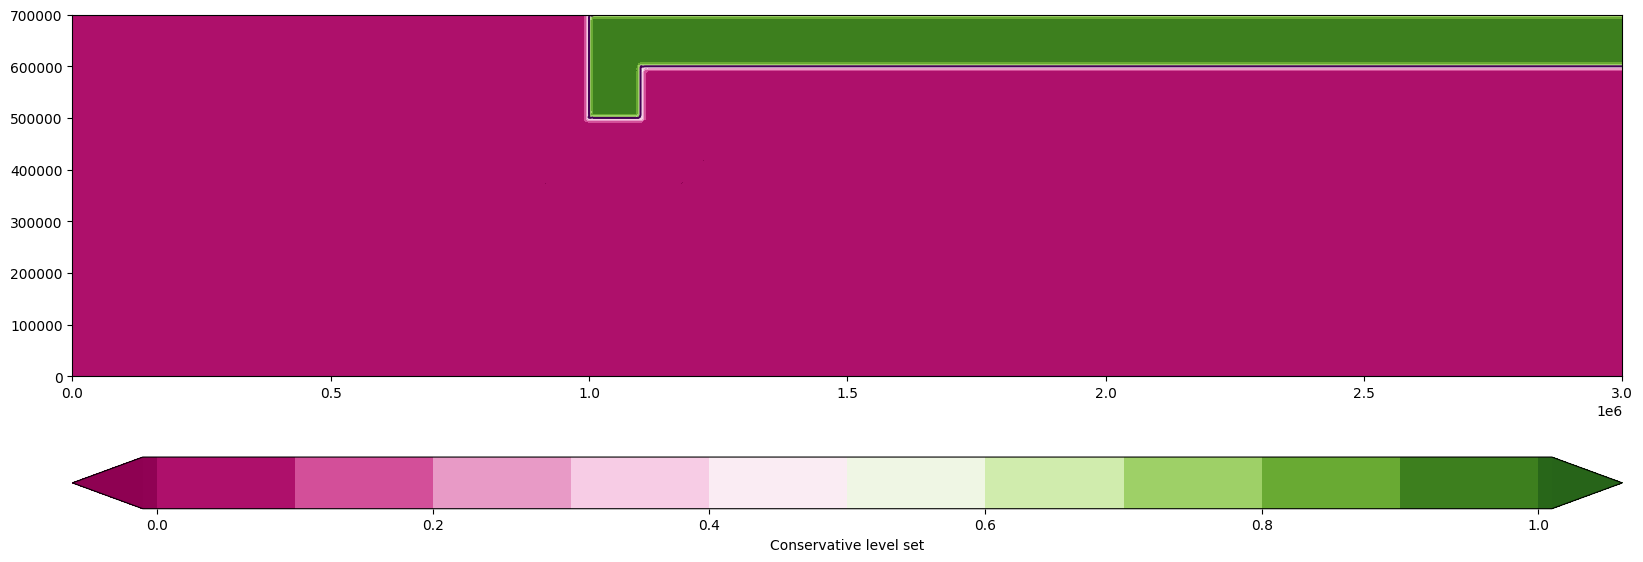

In [5]:
fig, axes = plt.subplots(figsize=(20, 7))
axes.set_aspect("equal")

level_set_levels = [-0.01, *linspace(0.0, 1.0, 11), 1.01]
contourf = tricontourf(
    psi, levels=level_set_levels, cmap="PiYG", extend="both", axes=axes
)
tricontour(psi, levels=[0.5], axes=axes)
fig.colorbar(
    contourf,
    orientation="horizontal",
    aspect=30,
    label="Conservative level set",
    spacing="proportional",
)

We next define the material fields and instantiate the approximation. Here, the system
of equations is dimensional and only includes compositional buoyancy under the
Boussinesq approximation. Moreover, density and viscosity vary through space from one
material to another. As a result, to define the system, we set the value of the
gravitational acceleration and define density and viscosity as material fields, with
their respective values for each individual material. To this end, we use the
`material_field` function, which also permits defining the transition of the physical
property at the material interface. We provide these objects to our approximation.

In [6]:
# Material fields defined based on each material value and location
mu = material_field(psi, [mu_mantle := 1e21, mu_slab := 1e23], interface="geometric")
rho_material = material_field(
    psi, [rho_mantle := 3200.0, rho_slab := 3300.0], interface="sharp"
)

# We set the Rayleigh number to 0.0 to indicate explicitly the absence of thermal
# buoyancy and the compositional Rayleigh number to 1.0 to enable compositional
# buoyancy.
approximation = BoussinesqApproximation(
    Ra=0.0, RaB=1.0, delta_rho=rho_material - rho_mantle, g=9.81, mu=mu
)

Let us now verify that the material fields have been correctly initialised. We plot
the density and viscosity across the domain.

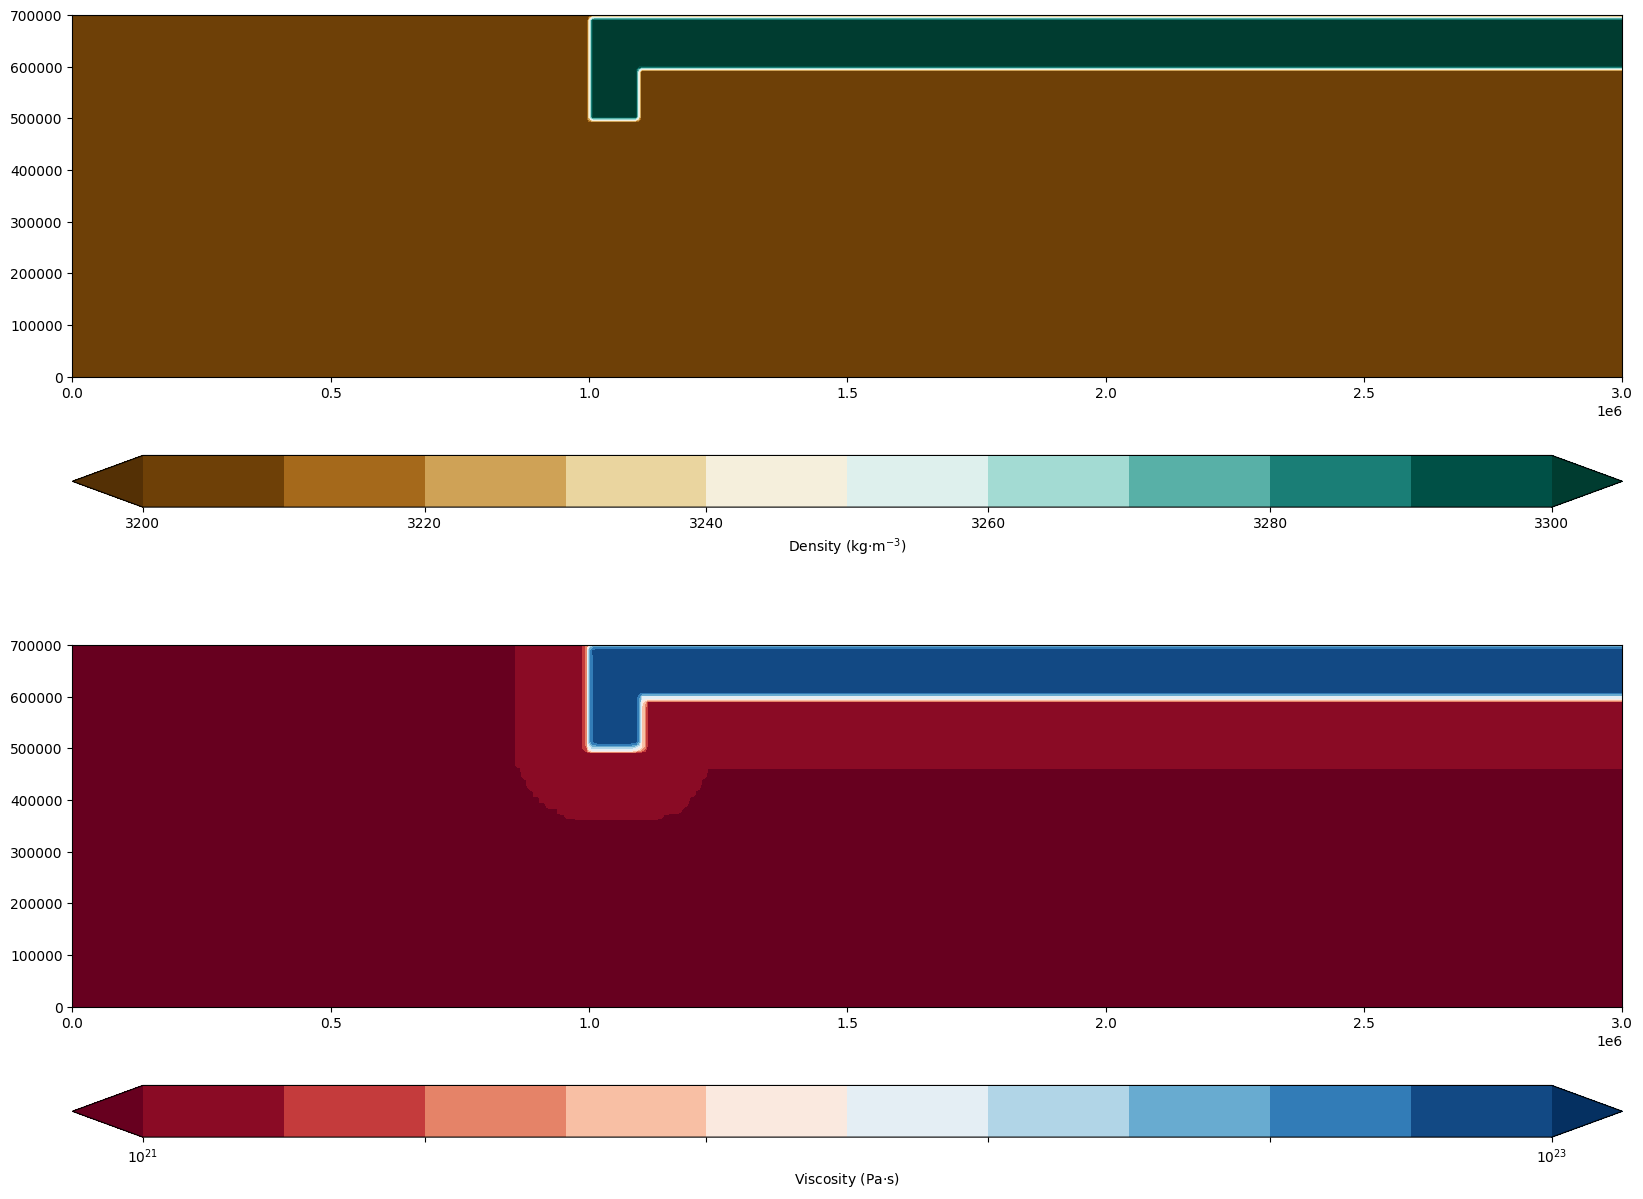

In [7]:
fig, axes = plt.subplots(nrows=2, figsize=(20, 15))
for ax in axes:
    ax.set_aspect("equal")

contours = tricontourf(
    Function(W).interpolate(rho_material),
    levels=linspace(rho_mantle, rho_slab, 11),
    cmap="BrBG",
    extend="both",
    axes=axes[0],
)
fig.colorbar(
    contours,
    ax=axes[0],
    orientation="horizontal",
    aspect=30,
    label="Density (kg$\\cdot$m$^{-3}$)",
)

contours = tricontourf(
    Function(W).interpolate(mu),
    levels=logspace(log10(mu_mantle), log10(mu_slab), 11),
    cmap="RdBu",
    norm=LogNorm(),
    extend="both",
    axes=axes[1],
)
fig.colorbar(
    contours,
    ax=axes[1],
    orientation="horizontal",
    aspect=30,
    label="Viscosity (Pa$\\cdot$s)",
)

As with the previous examples, we set up an instance of the `TimestepAdaptor` class
to control the time-step length (via a CFL criterion) whilst the simulation advances
in time. We specify the output frequency (in time units) at which fields will be
written for visualisation.

In [8]:
myr_to_seconds = 1e6 * 365.25 * 8.64e4
time_now = 0.0  # Initial time
# Frequency (based on simulation time) at which to output
output_frequency = 0.8 * myr_to_seconds
t_adapt = TimestepAdaptor(
    time_step, u, V, target_cfl=0.6, maximum_timestep=output_frequency
)  # Current level-set advection requires a CFL condition that should not exceed 0.6.

Here, we set up the variational problem for the Stokes and level-set systems. The
former depends on the approximation defined above, and the latter includes both
advection and reinitialisation components. Subcycling is available for level-set
advection and is mainly useful when the problem at hand involves multiple CFL
conditions, with the CFL for level-set advection being the most restrictive. In terms
of boundary conditions, we supply the Stokes system with a free surface at the top
(assuming the density of the outside layer is 0.0) and free slip at all other
boundaries, while no boundary conditions are required for level-set advection, as the
numerical domain is closed.

In [9]:
stokes_bcs = {
    boundary.bottom: {"uy": 0.0},
    boundary.top: {"free_surface": {"delta_rho_fs": rho_material}},
    boundary.left: {"ux": 0.0},
    boundary.right: {"ux": 0.0},
}
# Instantiate a solver object for the Stokes system and perform a solve to obtain
# initial pressure and velocity fields. Providing the simulation's time step is required
# to solve the free-surface balance.
stokes_solver = StokesSolver(stokes, approximation, dt=time_step, bcs=stokes_bcs)
stokes_solver.solve()

# Instantiate a solver object for level-set advection and reinitialisation. G-ADOPT
# provides default values for most arguments; we only provide those that do not have
# one.
adv_kwargs = {"u": u, "timestep": time_step}
reini_kwargs = {"epsilon": epsilon}
level_set_solver = LevelSetSolver(psi, adv_kwargs=adv_kwargs, reini_kwargs=reini_kwargs)

We now set up our output. To do so, we create the output file as a ParaView Data file
that uses the XML-based VTK file format. We also open a file for logging and
instantiate G-ADOPT's geodynamical diagnostic utility.

In [10]:
output_file = VTKFile("output.pvd")
output_file.write(*stokes.subfunctions, psi, time=time_now / myr_to_seconds)

plog = ParameterLog("params.log", mesh)
plog.log_str("step time dt u_rms slab_tip_depth")

gd = GeodynamicalDiagnostics(stokes)

Finally, we initiate the time loop, which runs until the simulation end time is
attained.

In [11]:
step = 0  # A counter to keep track of looping
output_counter = 1  # A counter to keep track of outputting
time_end = 60.0 * myr_to_seconds
while True:
    # Update timestep
    if time_end - time_now < output_frequency:
        t_adapt.maximum_timestep = time_end - time_now
    t_adapt.update_timestep()

    # Advect and reinitialise level set
    level_set_solver.solve()
    # Solve Stokes sytem
    stokes_solver.solve()

    # Increment iteration count and time
    step += 1
    time_now += float(time_step)

    # Log diagnostics
    slab_tip_depth = (
        domain_dims[1] - min_max_height(psi, epsilon, side=1, mode="min")
    ) / 1e3
    plog.log_str(f"{step} {time_now} {float(time_step)} {gd.u_rms()} {slab_tip_depth}")

    # Write output
    if time_now >= output_counter * output_frequency - 1e-16:
        output_file.write(*stokes.subfunctions, psi, time=time_now / myr_to_seconds)
        output_counter += 1

    # Check if simulation has completed
    if time_now >= time_end:
        plog.close()  # Close logging file

        # Checkpoint solution fields to disk
        with CheckpointFile("Final_State.h5", "w") as final_checkpoint:
            final_checkpoint.save_mesh(mesh)
            final_checkpoint.save_function(stokes, name="Stokes")
            final_checkpoint.save_function(psi, name="Level set")

        log("Reached end of simulation -- exiting time-step loop")
        break

Reached end of simulation -- exiting time-step loop


Let us finally examine the location of the material interface and the free surface at
the end of the simulation.

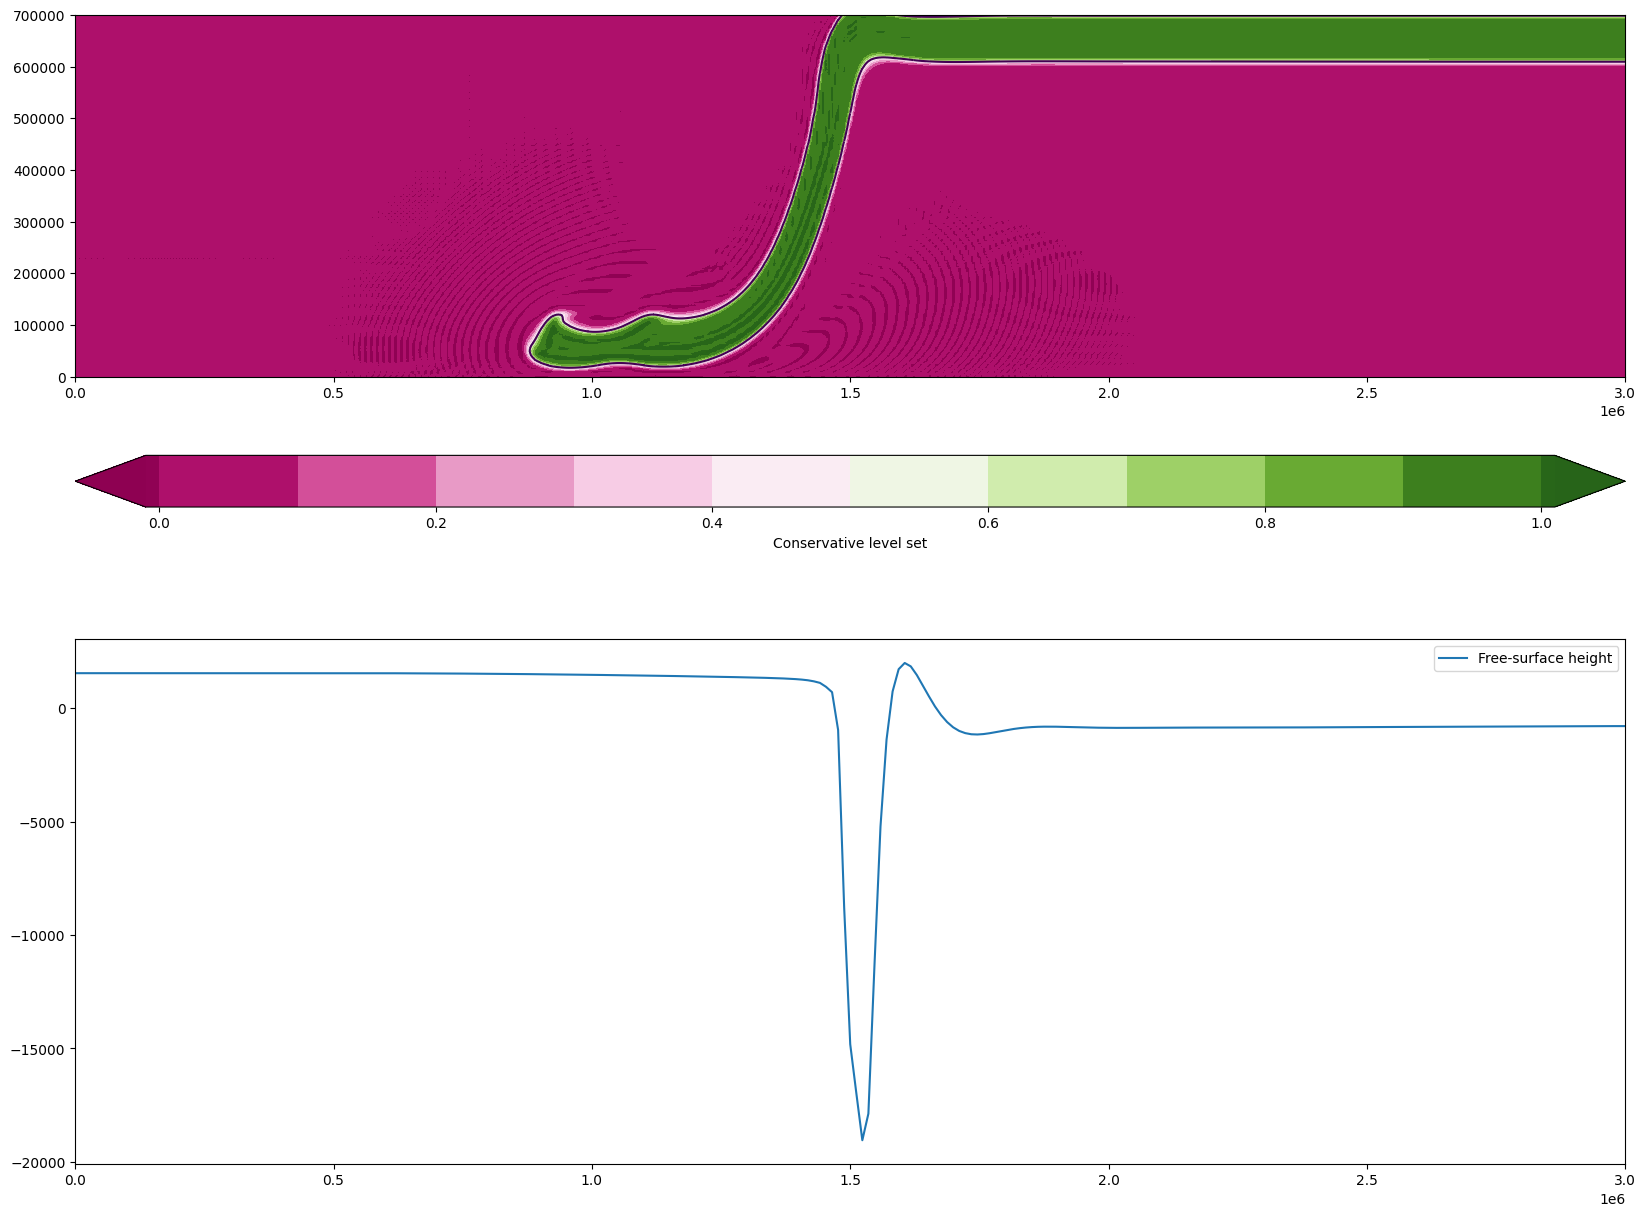

In [12]:
fig, axes = plt.subplots(nrows=2, figsize=(20, 15))
axes[0].set_aspect("equal")
axes[1].set_xlim((0.0, domain_dims[0]))

contourf = tricontourf(
    psi, levels=level_set_levels, cmap="PiYG", extend="both", axes=axes[0]
)
tricontour(psi, levels=[0.5], axes=axes[0])
fig.colorbar(
    contourf,
    ax=axes[0],
    orientation="horizontal",
    aspect=30,
    label="Conservative level set",
    spacing="proportional",
)

reader = pv.get_reader("output.pvd")
reader.set_active_time_point(len(reader.time_values) - 1)
data = reader.read()[0]
sample_over_line = data.sample_over_line(
    [0.0, domain_dims[1], 0.0], [*domain_dims, 0.0], resolution=mesh_elements[0]
)
axes[1].plot(
    linspace(0.0, domain_dims[0], mesh_elements[0] + 1),
    sample_over_line["Free surface"],
    label="Free-surface height",
)
axes[1].legend()